# Market Segmentation Using K-means Clustering

In [1]:
#Importing all the ncessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [2]:
#Reading data from file

df_bikes = pd.read_excel('bikes.xlsx')

df_bikeshops = pd.read_excel('bikeshops.xlsx')

df_orders = pd.read_excel('orders.xlsx')

In [3]:
#Understanding all the bike dataset
df_bikes.head()

,bike.id,model,category1,category2,frame,price
0,1,Supersix Evo Black Inc.,Road,Elite Road,Carbon,12790
1,2,Supersix Evo Hi-Mod Team,Road,Elite Road,Carbon,10660
2,3,Supersix Evo Hi-Mod Dura Ace 1,Road,Elite Road,Carbon,7990
3,4,Supersix Evo Hi-Mod Dura Ace 2,Road,Elite Road,Carbon,5330
4,5,Supersix Evo Hi-Mod Utegra,Road,Elite Road,Carbon,4260


In [4]:
#Understanding all the bike columns
df_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 6 columns):
bike.id      97 non-null int64
model        97 non-null object
category1    97 non-null object
category2    97 non-null object
frame        97 non-null object
price        97 non-null int64
dtypes: int64(2), object(4)
memory usage: 4.6+ KB


In [5]:
#Understanding all the bikeshop dataset
df_bikeshops.head()

,bikeshop.id,bikeshop.name,bikeshop.city,bikeshop.state,latitude,longitude
0,1,Pittsburgh Mountain Machines,Pittsburgh,PA,40.440625,-79.995886
1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881
2,3,Columbus Race Equipment,Columbus,OH,39.961176,-82.998794
3,4,Detroit Cycles,Detroit,MI,42.331427,-83.045754
4,5,Cincinnati Speed,Cincinnati,OH,39.103118,-84.512020


In [6]:
#Understanding all the bikeshop columns
df_bikeshops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
bikeshop.id       30 non-null int64
bikeshop.name     30 non-null object
bikeshop.city     30 non-null object
bikeshop.state    30 non-null object
latitude          30 non-null float64
longitude         30 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.5+ KB


In [7]:
#Understanding all the orders dataset
df_orders.head()

,Unnamed: 0,order.id,order.line,order.date,customer.id,product.id,quantity
0,1,1,1,2011-01-07,2,48,1
1,2,1,2,2011-01-07,2,52,1
2,3,2,1,2011-01-10,10,76,1
3,4,2,2,2011-01-10,10,52,1
4,5,3,1,2011-01-10,6,2,1


In [8]:
#Understanding all the orders columns
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15644 entries, 0 to 15643
Data columns (total 7 columns):
Unnamed: 0     15644 non-null int64
order.id       15644 non-null int64
order.line     15644 non-null int64
order.date     15644 non-null datetime64[ns]
customer.id    15644 non-null int64
product.id     15644 non-null int64
quantity       15644 non-null int64
dtypes: datetime64[ns](1), int64(6)
memory usage: 855.6 KB


For the Cannondale orders, our hypothesis is that bike shops purchase Cannondale bike models based on features such as Mountain or Road, Bikes and price tier (high/premium or low/affordable). The bike model features (e.g. price,
category, etc.) will be used for assessing the preferences of the shop clusters.

We select quantity purchased as the unit of measure to cluster on because total value can be skewed by the bike unit price.

# Step 1: Data preprocessing

In [9]:
#Merging all three databases together and removing the iuncessary columns
df_extendedOrders1 = pd.merge(df_orders, df_bikeshops, right_on='bikeshop.id', left_on='customer.id')
del df_extendedOrders1['Unnamed: 0']
df_extendedOrders = pd.merge(df_extendedOrders1, df_bikes, right_on='bike.id', left_on='product.id')

df_extendedOrders.head()

,order.id,order.line,order.date,customer.id,product.id,quantity,bikeshop.id,bikeshop.name,bikeshop.city,bikeshop.state,latitude,longitude,bike.id,model,category1,category2,frame,price
0,1,1,2011-01-07,2,48,1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881,48,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,6070
1,132,6,2011-05-13,2,48,1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881,48,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,6070
2,507,2,2012-06-26,2,48,1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881,48,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,6070
3,528,18,2012-07-16,2,48,1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881,48,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,6070
4,691,13,2013-02-05,2,48,1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881,48,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,6070


In [10]:
#Converting the unit price to a categorical value high/low by using the median price as split point
median_unit_price = df_extendedOrders['price'].median()

df_extendedOrders['priceCategory'] = np.where(df_extendedOrders['price'] >= median_unit_price, 'High', 'Low')

df_extendedOrders.head()

,order.id,order.line,order.date,customer.id,product.id,quantity,bikeshop.id,bikeshop.name,bikeshop.city,bikeshop.state,latitude,longitude,bike.id,model,category1,category2,frame,price,priceCategory
0,1,1,2011-01-07,2,48,1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881,48,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,6070,High
1,132,6,2011-05-13,2,48,1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881,48,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,6070,High
2,507,2,2012-06-26,2,48,1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881,48,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,6070,High
3,528,18,2012-07-16,2,48,1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881,48,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,6070,High
4,691,13,2013-02-05,2,48,1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881,48,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,6070,High


In [11]:
#Checking for any missing values in the combined dataframe

df_extendedOrders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15644 entries, 0 to 15643
Data columns (total 19 columns):
order.id          15644 non-null int64
order.line        15644 non-null int64
order.date        15644 non-null datetime64[ns]
customer.id       15644 non-null int64
product.id        15644 non-null int64
quantity          15644 non-null int64
bikeshop.id       15644 non-null int64
bikeshop.name     15644 non-null object
bikeshop.city     15644 non-null object
bikeshop.state    15644 non-null object
latitude          15644 non-null float64
longitude         15644 non-null float64
bike.id           15644 non-null int64
model             15644 non-null object
category1         15644 non-null object
category2         15644 non-null object
frame             15644 non-null object
price             15644 non-null int64
priceCategory     15644 non-null object
dtypes: datetime64[ns](1), float64(2), int64(8), object(8)
memory usage: 2.4+ MB


In [12]:
#Grouping the data by model & model features and summarize by quantity purchased

df_groupOrders = df_extendedOrders.groupby(["bikeshop.name", "model", "category1", "category2", "frame", "priceCategory"])["quantity"].sum()
df_groupOrders = pd.DataFrame(df_groupOrders)
df_groupOrders = df_groupOrders.reset_index()
df_groupOrders.head()

,bikeshop.name,model,category1,category2,frame,priceCategory,quantity
0,Albuquerque Cycles,Bad Habit 1,Mountain,Trail,Aluminum,High,5
1,Albuquerque Cycles,Bad Habit 2,Mountain,Trail,Aluminum,Low,2
2,Albuquerque Cycles,Beast of the East 1,Mountain,Trail,Aluminum,High,3
3,Albuquerque Cycles,Beast of the East 2,Mountain,Trail,Aluminum,Low,3
4,Albuquerque Cycles,Beast of the East 3,Mountain,Trail,Aluminum,Low,1


In [13]:
# Pivot of the table to allocate aggregated quantitites across different bikeshops

df_pivot = pd.pivot_table(df_groupOrders,index= ["model", "category1", "category2", "frame", "priceCategory"], columns='bikeshop.name', values='quantity')
# df_pivot = df_pivot.reset_index()
df_pivot = df_pivot.fillna(0)
df_pivot.columns.name= None
df_pivot.head()

,,,,,Albuquerque Cycles,Ann Arbor Speed,Austin Cruisers,Cincinnati Speed,Columbus Race Equipment,Dallas Cycles,Denver Bike Shop,Detroit Cycles,Indianapolis Velocipedes,Ithaca Mountain Climbers,...,Philadelphia Bike Shop,Phoenix Bi-peds,Pittsburgh Mountain Machines,Portland Bi-peds,Providence Bi-peds,San Antonio Bike Shop,San Francisco Cruisers,Seattle Race Equipment,Tampa 29ers,Wichita Speed
model,category1,category2,frame,priceCategory,,,,,,,,,,,,,,,,,,,,,
Bad Habit 1,Mountain,Trail,Aluminum,High,5.0,4.0,2.0,2.0,4.0,3.0,27.0,5.0,2.0,23.0,...,6.0,16.0,6.0,7.0,5.0,4.0,1.0,2.0,4.0,3.0
Bad Habit 2,Mountain,Trail,Aluminum,Low,2.0,6.0,1.0,0.0,0.0,4.0,32.0,8.0,1.0,14.0,...,1.0,27.0,1.0,7.0,13.0,0.0,1.0,1.0,0.0,0.0
Beast of the East 1,Mountain,Trail,Aluminum,High,3.0,9.0,2.0,0.0,0.0,1.0,42.0,6.0,3.0,27.0,...,0.0,18.0,2.0,7.0,5.0,1.0,0.0,2.0,2.0,0.0
Beast of the East 2,Mountain,Trail,Aluminum,Low,3.0,6.0,2.0,0.0,2.0,1.0,35.0,3.0,3.0,23.0,...,0.0,33.0,4.0,10.0,8.0,2.0,1.0,3.0,6.0,1.0
Beast of the East 3,Mountain,Trail,Aluminum,Low,1.0,2.0,0.0,0.0,1.0,1.0,39.0,6.0,0.0,13.0,...,5.0,23.0,1.0,13.0,4.0,6.0,0.0,1.0,2.0,0.0


In [14]:
#Normalizng the quantity data to tackle unadjusted quantities
#Converting the order quantities to proportion of the total bikes purchased by a bikeshop

for i in range(df_pivot.shape[1]):
    df_pivot.iloc[: , i] = df_pivot.iloc[: , i]/df_pivot.iloc[: , i].sum()
    
df_pivot.head()

,,,,,Albuquerque Cycles,Ann Arbor Speed,Austin Cruisers,Cincinnati Speed,Columbus Race Equipment,Dallas Cycles,Denver Bike Shop,Detroit Cycles,Indianapolis Velocipedes,Ithaca Mountain Climbers,...,Philadelphia Bike Shop,Phoenix Bi-peds,Pittsburgh Mountain Machines,Portland Bi-peds,Providence Bi-peds,San Antonio Bike Shop,San Francisco Cruisers,Seattle Race Equipment,Tampa 29ers,Wichita Speed
model,category1,category2,frame,priceCategory,,,,,,,,,,,,,,,,,,,,,
Bad Habit 1,Mountain,Trail,Aluminum,High,0.017483,0.006645,0.008130,0.005115,0.010152,0.012821,0.011734,0.009921,0.006270,0.018196,...,0.024490,0.011276,0.015915,0.010870,0.009225,0.021505,0.002674,0.015625,0.019417,0.005917
Bad Habit 2,Mountain,Trail,Aluminum,Low,0.006993,0.009967,0.004065,0.000000,0.000000,0.017094,0.013907,0.015873,0.003135,0.011076,...,0.004082,0.019027,0.002653,0.010870,0.023985,0.000000,0.002674,0.007812,0.000000,0.000000
Beast of the East 1,Mountain,Trail,Aluminum,High,0.010490,0.014950,0.008130,0.000000,0.000000,0.004274,0.018253,0.011905,0.009404,0.021361,...,0.000000,0.012685,0.005305,0.010870,0.009225,0.005376,0.000000,0.015625,0.009709,0.000000
Beast of the East 2,Mountain,Trail,Aluminum,Low,0.010490,0.009967,0.008130,0.000000,0.005076,0.004274,0.015211,0.005952,0.009404,0.018196,...,0.000000,0.023256,0.010610,0.015528,0.014760,0.010753,0.002674,0.023438,0.029126,0.001972
Beast of the East 3,Mountain,Trail,Aluminum,Low,0.003497,0.003322,0.000000,0.000000,0.002538,0.004274,0.016949,0.011905,0.000000,0.010285,...,0.020408,0.016209,0.002653,0.020186,0.007380,0.032258,0.000000,0.007812,0.009709,0.000000


In [15]:
# Calculating pivot transpose to perform K means clustering
df_pivot_transpose = df_pivot.transpose()
df_pivot_transpose.head()

model,Bad Habit 1,Bad Habit 2,Beast of the East 1,Beast of the East 2,Beast of the East 3,CAAD Disc Ultegra,CAAD12 105,CAAD12 Black Inc,CAAD12 Disc 105,CAAD12 Disc Dura Ace,...,Synapse Sora,Trail 1,Trail 2,Trail 3,Trail 4,Trail 5,Trigger Carbon 1,Trigger Carbon 2,Trigger Carbon 3,Trigger Carbon 4
category1,Mountain,Mountain,Mountain,Mountain,Mountain,Road,Road,Road,Road,Road,...,Road,Mountain,Mountain,Mountain,Mountain,Mountain,Mountain,Mountain,Mountain,Mountain
category2,Trail,Trail,Trail,Trail,Trail,Elite Road,Elite Road,Elite Road,Elite Road,Elite Road,...,Endurance Road,Sport,Sport,Sport,Sport,Sport,Over Mountain,Over Mountain,Over Mountain,Over Mountain
frame,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,...,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Carbon,Carbon,Carbon,Carbon
priceCategory,High,Low,High,Low,Low,Low,Low,High,Low,High,...,Low,Low,Low,Low,Low,Low,High,High,High,High
Albuquerque Cycles,0.017483,0.006993,0.01049,0.010490,0.003497,0.013986,0.006993,0.000000,0.013986,0.048951,...,0.000000,0.000000,0.003497,0.006993,0.017483,0.010490,0.006993,0.003497,0.006993,0.006993
Ann Arbor Speed,0.006645,0.009967,0.01495,0.009967,0.003322,0.026578,0.014950,0.016611,0.014950,0.008306,...,0.009967,0.009967,0.014950,0.009967,0.003322,0.011628,0.000000,0.000000,0.000000,0.011628
Austin Cruisers,0.008130,0.004065,0.00813,0.008130,0.000000,0.020325,0.020325,0.004065,0.024390,0.008130,...,0.020325,0.016260,0.016260,0.016260,0.008130,0.008130,0.000000,0.000000,0.000000,0.016260
Cincinnati Speed,0.005115,0.000000,0.00000,0.000000,0.000000,0.015345,0.010230,0.015345,0.007673,0.017903,...,0.012788,0.000000,0.002558,0.002558,0.002558,0.000000,0.010230,0.007673,0.010230,0.020460
Columbus Race Equipment,0.010152,0.000000,0.00000,0.005076,0.002538,0.010152,0.027919,0.027919,0.025381,0.012690,...,0.015228,0.002538,0.002538,0.005076,0.000000,0.000000,0.010152,0.005076,0.017766,0.005076


# Step 2: Perform k-Means Clustering

# Elbow Method to determine optimum value of K

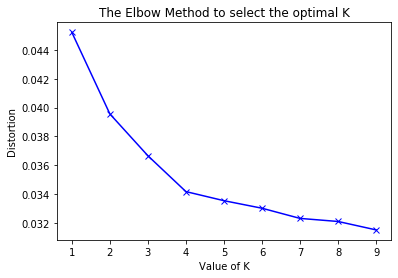

In [16]:
#Determining Value K for Kmeans Clustering using elbow method 

distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 0).fit(df_pivot)
    kmeanModel.fit(df_pivot)
    distortions.append(sum(np.min(cdist(df_pivot, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_pivot.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('Value of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method to select the optimal K')
plt.show()

# Silhouette Method to determine optimum value of K

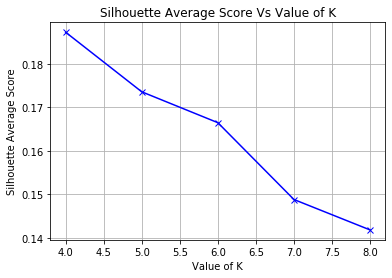

In [17]:
#Silhouette Method to determine optimum value of K

sil = []
for k in range(4,9):
  kmeans = KMeans(n_clusters = k, random_state = 0).fit(df_pivot)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_pivot, labels, metric = 'euclidean'))
      
Kset = [k for k in range(4,9)]

#Plotting the silhouette_score 
plt.plot(Kset, sil, 'bx-')     
plt.xlabel('Value of K')
plt.ylabel("Silhouette Average Score")
plt.title("Silhouette Average Score Vs Value of K")
plt.grid()
plt.show()

Value of K is 4

I decided to use both Elbow and silhouette method to estimate the opitmum value of K

Based on both the methods the optimum value of K is 4

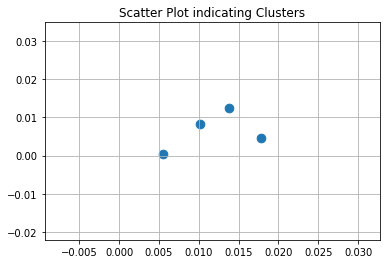

In [18]:
#Development of KMeans clustering model

clustModel = KMeans(n_clusters = 4, random_state = 10)
clustModel.fit(df_pivot_transpose)
clust_labels = clustModel.predict(df_pivot_transpose)

#Assinging cluster label for each shop 
df_pivot_transpose['clust_labels'] = clust_labels

#Plotting the cluster centers
cluster_centers=clustModel.cluster_centers_
x = cluster_centers[:,0]
y = cluster_centers[:,1]
plt.scatter(x, y, s=75)
plt.title("Scatter Plot indicating Clusters")
plt.grid()
plt.show()

In [19]:
df_pivot_transpose.shape

(30, 98)

In [20]:
len(cluster_centers[0])

97

# Step 3: Analyze the result

Inspect the groups find out which shops are grouped together and analyze the factors related to the model 

In [21]:
# Dispalying Shop Names in each segment for K means clustering
clust_shopNames = []

clust_no = len(df_pivot_transpose['clust_labels'].value_counts())
for i in range(0,clust_no):
    clust_shopNames.append(df_pivot_transpose.index[df_pivot_transpose['clust_labels'] == i].tolist())
print("Segments of shops according to K MEans Clustering")
for i in range(len(clust_shopNames)):
    print("----------------------------------------------")
    print("*** Segment: X" + str(i+1) + " ***")
    print(*clust_shopNames[i], sep = "\n")


Segments of shops according to K MEans Clustering
----------------------------------------------
*** Segment: X1 ***
Ithaca Mountain Climbers
Pittsburgh Mountain Machines
Tampa 29ers
----------------------------------------------
*** Segment: X2 ***
Ann Arbor Speed
Austin Cruisers
Indianapolis Velocipedes
Miami Race Equipment
Nashville Cruisers
New Orleans Velocipedes
Oklahoma City Race Equipment
Seattle Race Equipment
----------------------------------------------
*** Segment: X3 ***
Cincinnati Speed
Columbus Race Equipment
Las Vegas Cycles
Louisville Race Equipment
San Francisco Cruisers
Wichita Speed
----------------------------------------------
*** Segment: X4 ***
Albuquerque Cycles
Dallas Cycles
Denver Bike Shop
Detroit Cycles
Kansas City 29ers
Los Angeles Cycles
Minneapolis Bike Shop
New York Cycles
Philadelphia Bike Shop
Phoenix Bi-peds
Portland Bi-peds
Providence Bi-peds
San Antonio Bike Shop


In [22]:
#Combining cluster centroids with bike models for feature inspection

df_inspect = df_pivot.reset_index()
df_inspect = df_inspect[['model', 'category1', 'category2', 'frame', 'priceCategory']]
temp_df = pd.DataFrame(cluster_centers).transpose()

temp_df = temp_df.rename(columns={0: 'X1',1: 'X2',2: 'X3',3: 'X4'})
df_result = pd.concat([df_inspect, temp_df], axis=1, join='inner')
df_result

,model,category1,category2,frame,priceCategory,X1,X2,X3,X4
0,Bad Habit 1,Mountain,Trail,Aluminum,High,0.017843,0.010127,5.509305e-03,0.013803
1,Bad Habit 2,Mountain,Trail,Aluminum,Low,0.004576,0.008157,4.456328e-04,0.012405
2,Beast of the East 1,Mountain,Trail,Aluminum,High,0.012125,0.012970,2.670940e-04,0.012339
3,Beast of the East 2,Mountain,Trail,Aluminum,Low,0.019311,0.010810,2.464269e-03,0.012381
4,Beast of the East 3,Mountain,Trail,Aluminum,Low,0.007549,0.005640,1.801082e-03,0.013183
5,CAAD Disc Ultegra,Road,Elite Road,Aluminum,Low,0.000884,0.018546,1.284989e-02,0.011574
6,CAAD12 105,Road,Elite Road,Aluminum,Low,0.000527,0.014615,1.319158e-02,0.014984
7,CAAD12 Black Inc,Road,Elite Road,Aluminum,High,0.004142,0.011152,1.947096e-02,0.004709
8,CAAD12 Disc 105,Road,Elite Road,Aluminum,Low,0.000264,0.015795,1.401259e-02,0.016751
9,CAAD12 Disc Dura Ace,Road,Elite Road,Aluminum,High,0.019569,0.008316,1.642994e-02,0.007462


For each cluster, arranging top 10 bike models by cluster in descending order to analyze the similar features of cluster.

In [23]:
#Arraning top 10 bike models for cluster 1
df_result[['model','category1','category2','frame','priceCategory','X1']].sort_values('X1', ascending=False).head(10)

,model,category1,category2,frame,priceCategory,X1
49,Scalpel-Si Carbon 3,Mountain,Cross Country Race,Carbon,High,0.034269
41,Jekyll Carbon 4,Mountain,Over Mountain,Carbon,High,0.030282
45,Scalpel 29 Carbon Race,Mountain,Cross Country Race,Carbon,High,0.028039
95,Trigger Carbon 3,Mountain,Over Mountain,Carbon,High,0.025935
34,Habit Carbon 2,Mountain,Trail,Carbon,High,0.023375
96,Trigger Carbon 4,Mountain,Over Mountain,Carbon,High,0.023261
19,Catalyst 4,Mountain,Sport,Aluminum,Low,0.021564
39,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,High,0.021079
65,Supersix Evo Hi-Mod Dura Ace 2,Road,Elite Road,Carbon,High,0.021058
94,Trigger Carbon 2,Mountain,Over Mountain,Carbon,High,0.021043


The top 10 models in this cluster are of high price and mountain.
Almost all the models are of the carbon frame.

In [24]:
#Arraning top 10 bike models for cluster 2
df_result[['model','category1','category2','frame','priceCategory','X2']].sort_values('X2', ascending=False).head(10)

,model,category1,category2,frame,priceCategory,X2
82,Synapse Disc Tiagra,Road,Endurance Road,Aluminum,Low,0.024608
10,CAAD12 Red,Road,Elite Road,Aluminum,High,0.022889
87,Synapse Sora,Road,Endurance Road,Aluminum,Low,0.022305
56,Slice Ultegra,Road,Triathalon,Carbon,High,0.022077
70,Supersix Evo Ultegra 3,Road,Elite Road,Carbon,High,0.021857
80,Synapse Disc 105,Road,Endurance Road,Aluminum,Low,0.021122
78,Synapse Carbon Ultegra 4,Road,Endurance Road,Carbon,Low,0.020372
11,CAAD12 Ultegra,Road,Elite Road,Aluminum,Low,0.020073
57,Slice Ultegra D12,Road,Triathalon,Carbon,High,0.019531
71,Supersix Evo Ultegra 4,Road,Elite Road,Carbon,Low,0.019435


The top 10 models in this cluster are mix of high and low price models. 
All the model are of category road for the primariy category

In [25]:
#Arraning top 10 bike models for cluster 3
df_result[['model','category1','category2','frame','priceCategory','X3']].sort_values('X3', ascending=False).head(10)

,model,category1,category2,frame,priceCategory,X3
84,Synapse Hi-Mod Disc Red,Road,Endurance Road,Carbon,High,0.024675
54,Slice Hi-Mod Black Inc.,Road,Triathalon,Carbon,High,0.023494
64,Supersix Evo Hi-Mod Dura Ace 1,Road,Elite Road,Carbon,High,0.023053
55,Slice Hi-Mod Dura Ace D12,Road,Triathalon,Carbon,High,0.022961
86,Synapse Hi-Mod Dura Ace,Road,Endurance Road,Carbon,High,0.021672
10,CAAD12 Red,Road,Elite Road,Aluminum,High,0.021196
75,Synapse Carbon Disc Ultegra,Road,Endurance Road,Carbon,High,0.020239
70,Supersix Evo Ultegra 3,Road,Elite Road,Carbon,High,0.020187
67,Supersix Evo Hi-Mod Utegra,Road,Elite Road,Carbon,High,0.019819
83,Synapse Hi-Mod Disc Black Inc.,Road,Endurance Road,Carbon,High,0.019755


The top 10 models in this cluster are high price models. 
All the model are of category road for the primariy category and majority of them have carbon frame

In [26]:
#Arraning top 10 bike models for cluster 4
df_result[['model','category1','category2','frame','priceCategory','X4']].sort_values('X4', ascending=False).head(10)

,model,category1,category2,frame,priceCategory,X4
21,F-Si 2,Mountain,Cross Country Race,Aluminum,Low,0.020334
56,Slice Ultegra,Road,Triathalon,Carbon,High,0.018821
25,F-Si Carbon 4,Mountain,Cross Country Race,Carbon,High,0.018444
18,Catalyst 3,Mountain,Sport,Aluminum,Low,0.018260
8,CAAD12 Disc 105,Road,Elite Road,Aluminum,Low,0.016751
74,Synapse Carbon Disc 105,Road,Endurance Road,Carbon,Low,0.016062
14,CAAD8 Sora,Road,Elite Road,Aluminum,Low,0.015626
92,Trail 5,Mountain,Sport,Aluminum,Low,0.015532
88,Trail 1,Mountain,Sport,Aluminum,Low,0.015381
30,Habit 4,Mountain,Trail,Aluminum,High,0.015225


The majority of the top 10 models in this cluster are low price models. 
All the model are mix of category road and mountain. The frame used for these models are again mix of carbon and aluminum

# Step 4: Hierarchical Clustering Implementation

In [27]:
#Using the dataframe df_pivot_transpose for hierarchical clustering
df_pivot_transpose.head(3)

model,Bad Habit 1,Bad Habit 2,Beast of the East 1,Beast of the East 2,Beast of the East 3,CAAD Disc Ultegra,CAAD12 105,CAAD12 Black Inc,CAAD12 Disc 105,CAAD12 Disc Dura Ace,...,Trail 1,Trail 2,Trail 3,Trail 4,Trail 5,Trigger Carbon 1,Trigger Carbon 2,Trigger Carbon 3,Trigger Carbon 4,clust_labels
category1,Mountain,Mountain,Mountain,Mountain,Mountain,Road,Road,Road,Road,Road,...,Mountain,Mountain,Mountain,Mountain,Mountain,Mountain,Mountain,Mountain,Mountain,
category2,Trail,Trail,Trail,Trail,Trail,Elite Road,Elite Road,Elite Road,Elite Road,Elite Road,...,Sport,Sport,Sport,Sport,Sport,Over Mountain,Over Mountain,Over Mountain,Over Mountain,
frame,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,...,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Carbon,Carbon,Carbon,Carbon,
priceCategory,High,Low,High,Low,Low,Low,Low,High,Low,High,...,Low,Low,Low,Low,Low,High,High,High,High,
Albuquerque Cycles,0.017483,0.006993,0.01049,0.010490,0.003497,0.013986,0.006993,0.000000,0.013986,0.048951,...,0.000000,0.003497,0.006993,0.017483,0.010490,0.006993,0.003497,0.006993,0.006993,3
Ann Arbor Speed,0.006645,0.009967,0.01495,0.009967,0.003322,0.026578,0.014950,0.016611,0.014950,0.008306,...,0.009967,0.014950,0.009967,0.003322,0.011628,0.000000,0.000000,0.000000,0.011628,1
Austin Cruisers,0.008130,0.004065,0.00813,0.008130,0.000000,0.020325,0.020325,0.004065,0.024390,0.008130,...,0.016260,0.016260,0.016260,0.008130,0.008130,0.000000,0.000000,0.000000,0.016260,1


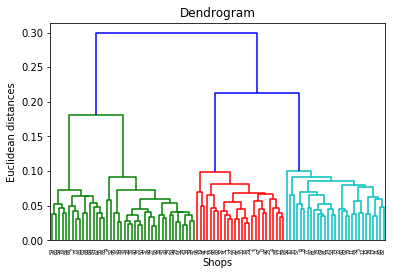

In [28]:
#Implementation og hirarchical clustering
#Reference: https://medium.com/@sametgirgin/hierarchical-clustering-model-in-5-steps-with-python-6c45087d4318

dendrogram = sch.dendrogram(sch.linkage(df_pivot, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Shops')
plt.ylabel('Euclidean distances')
plt.show()

After using the dendogram we decide the optimal value of clusters as 4 for hierarchical clustering

In [29]:
#Development of hirarchical clustering model
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(df_pivot_transpose)

#Assinging hirarchical clustering labels to all the shops 
df_pivot_transpose['HC_clust_labels'] = y_hc
df_pivot_transpose.head(5)

model,Bad Habit 1,Bad Habit 2,Beast of the East 1,Beast of the East 2,Beast of the East 3,CAAD Disc Ultegra,CAAD12 105,CAAD12 Black Inc,CAAD12 Disc 105,CAAD12 Disc Dura Ace,...,Trail 2,Trail 3,Trail 4,Trail 5,Trigger Carbon 1,Trigger Carbon 2,Trigger Carbon 3,Trigger Carbon 4,clust_labels,HC_clust_labels
category1,Mountain,Mountain,Mountain,Mountain,Mountain,Road,Road,Road,Road,Road,...,Mountain,Mountain,Mountain,Mountain,Mountain,Mountain,Mountain,Mountain,,
category2,Trail,Trail,Trail,Trail,Trail,Elite Road,Elite Road,Elite Road,Elite Road,Elite Road,...,Sport,Sport,Sport,Sport,Over Mountain,Over Mountain,Over Mountain,Over Mountain,,
frame,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,Aluminum,...,Aluminum,Aluminum,Aluminum,Aluminum,Carbon,Carbon,Carbon,Carbon,,
priceCategory,High,Low,High,Low,Low,Low,Low,High,Low,High,...,Low,Low,Low,Low,High,High,High,High,,
Albuquerque Cycles,0.017483,0.006993,0.01049,0.010490,0.003497,0.013986,0.006993,0.000000,0.013986,0.048951,...,0.003497,0.006993,0.017483,0.010490,0.006993,0.003497,0.006993,0.006993,3,0
Ann Arbor Speed,0.006645,0.009967,0.01495,0.009967,0.003322,0.026578,0.014950,0.016611,0.014950,0.008306,...,0.014950,0.009967,0.003322,0.011628,0.000000,0.000000,0.000000,0.011628,1,1
Austin Cruisers,0.008130,0.004065,0.00813,0.008130,0.000000,0.020325,0.020325,0.004065,0.024390,0.008130,...,0.016260,0.016260,0.008130,0.008130,0.000000,0.000000,0.000000,0.016260,1,1
Cincinnati Speed,0.005115,0.000000,0.00000,0.000000,0.000000,0.015345,0.010230,0.015345,0.007673,0.017903,...,0.002558,0.002558,0.002558,0.000000,0.010230,0.007673,0.010230,0.020460,2,2
Columbus Race Equipment,0.010152,0.000000,0.00000,0.005076,0.002538,0.010152,0.027919,0.027919,0.025381,0.012690,...,0.002538,0.005076,0.000000,0.000000,0.010152,0.005076,0.017766,0.005076,2,2


In [30]:
# Dispalying Shop Names in each segment for hirarchical clsutering
clust_shopNames1 = []

clust_no = len(df_pivot_transpose['HC_clust_labels'].value_counts())
for i in range(0,clust_no):
    clust_shopNames1.append(df_pivot_transpose.index[df_pivot_transpose['HC_clust_labels'] == i].tolist())
print("Segments of shops according to Hirarchical CLustering")
for i in range(len(clust_shopNames1)):
    print("----------------------------------------------")
    print("*** Segment: Y" + str(i+1) + " ***")
    print(*clust_shopNames1[i], sep = "\n")


Segments of shops according to Hirarchical CLustering
----------------------------------------------
*** Segment: Y1 ***
Albuquerque Cycles
Dallas Cycles
Denver Bike Shop
Detroit Cycles
Kansas City 29ers
Los Angeles Cycles
Minneapolis Bike Shop
New York Cycles
Philadelphia Bike Shop
Phoenix Bi-peds
Portland Bi-peds
Providence Bi-peds
San Antonio Bike Shop
----------------------------------------------
*** Segment: Y2 ***
Ann Arbor Speed
Austin Cruisers
Indianapolis Velocipedes
Miami Race Equipment
Nashville Cruisers
New Orleans Velocipedes
Oklahoma City Race Equipment
Seattle Race Equipment
----------------------------------------------
*** Segment: Y3 ***
Cincinnati Speed
Columbus Race Equipment
Las Vegas Cycles
Louisville Race Equipment
San Francisco Cruisers
Wichita Speed
----------------------------------------------
*** Segment: Y4 ***
Ithaca Mountain Climbers
Pittsburgh Mountain Machines
Tampa 29ers


Comparing the outcome of both the models:
    
The clusters formed by both the methods Hirarchical Clustering and KMeans Clustering are same.